In [3]:
%matplotlib inline
%load_ext rpy2.ipython

In [35]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(doParallel)
library(rwantshue)
library(RColorBrewer)

In [5]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [6]:
%%R
physeq = subset_samples(physeq,sample_sums(physeq)>1)

In [7]:
%%R
#run deseq on each subset of factors (day and amendment), return the factors, OTU ID, base mean, log2-fold change, 
# the standard error, and the p value associated with the response.

Dif_Abund = function(Trtmt,Month){
    physeq.pruned <- prune_samples(((sample_data(physeq)$Month == Month) & (sample_data(physeq)$Trtmt == Trtmt)) | ((sample_data(physeq)$Month == Month) & (sample_data(physeq)$Trtmt == "Quartz")),physeq)
    physeq.pruned = prune_taxa(taxa_sums(physeq.pruned) > 0, physeq.pruned)
#    physeq.pruned = prune_samples(sample_sums(physeq.pruned)>200, physeq.pruned)
    taxonomy <- data.frame(tax_table(physeq.pruned))
    dseq = phyloseq_to_deseq2(physeq.pruned, ~Trtmt)
    dseq$Trtmt = relevel(dseq$Trtmt,"Quartz")
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
    results = results(dseq)
    results$Month = Month
    results$Trtmt = Trtmt
    results = data.frame(results$Month,results$Trtmt,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy[,1:7])
    colnames(results) = c("Month","Trtmt","OTU","baseMean","l2FC","SE","pvalue","Kingdom","Phylum","Class","Order","Family","Genus","Species")
    results
    }

In [8]:
%%R
# Creating a matrix with the different combinations of variables for day and amendment
variables = expand.grid(Trtmt = c("Ferrihydrite"),
                        Month = c(2.5, 3))
variables

         Trtmt Month
1 Ferrihydrite   2.5
2 Ferrihydrite   3.0


In [9]:
%%R
# Joining the variables and the differential abundance
DA<-mdply(variables,Dif_Abund)

# Runs the  differential abundance function we created above on all the combinations of variables

converting counts to integer mode
converting counts to integer mode


In [10]:
%%R
threshold = function (thresh){
    dplyr::filter(DA, baseMean >= thresh) %>% 
    dplyr::mutate(padj = p.adjust(pvalue,"BH")) %>%
    dplyr::summarize(cutoff=thresh, count=sum(padj<=0.10, na.rm = TRUE))
}
# Takes our table of differential abundance values,
# and determines those for which the baseMean values is greater or equal to whatever we input as threshould
# Then, for any samples that meet that criterion, we add a column (mutate), where we adjust the p value 
# using the Benjamini & Hochberg correction
# Then we summarize the results, listiing the cutoff threshold, and then the total number of OTUs for which the 
# new adjusted p values is less than 0.10 (just a standard level used by others).
# Note we also specify that the functions are called using dplyr package ("dplyr::").

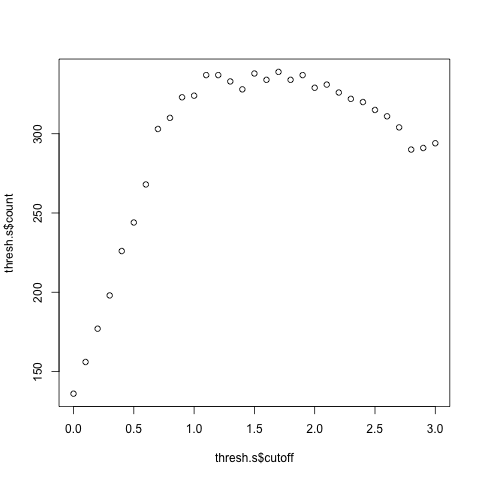

In [12]:
%%R
range = seq(0,3,0.1)
# Creates a range of numbers we are interested in for adjusted p values
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here (here, 0.3)

In [13]:
%%R
filter(DA,baseMean>=1.1) %>% mutate(padj = p.adjust(pvalue,"BH")) %>% write.csv("../../SeqData/l2fcQF.csv", row.names=FALSE)
# We take that differential abundance table we created above, and filter it to include only those samples 
# that had a baseMean value above the optimal cutoff we determined above.
# We then adjust the p values and save it as a csv.

In [14]:
%%R
l2fc<-read.csv("../../SeqData/l2fcQF.csv")
head(l2fc)

  Month        Trtmt      OTU  baseMean         l2FC        SE     pvalue
1   2.5 Ferrihydrite  69_2370 98.574879 -1.471505393 0.6549606 0.02465867
2   2.5 Ferrihydrite 67_26460  3.517955 -0.586719554 1.1149497 0.59872869
3   2.5 Ferrihydrite 96_50315  5.404495 -2.175936434 0.8637957 0.01176751
4   2.5 Ferrihydrite 58_38953  2.357967 -1.798248325 1.0626326 0.09059682
5   2.5 Ferrihydrite 73_37380  2.118435  0.001516736 1.2560646 0.99903653
6   2.5 Ferrihydrite 65_11911  2.641983 -0.166450689 0.8614801 0.84679076
   Kingdom         Phylum                 Class             Order
1 Bacteria  Fibrobacteres         Fibrobacteria           258ds10
2 Bacteria  Fibrobacteres         Fibrobacteria           258ds10
3 Bacteria  Fibrobacteres         Fibrobacteria           258ds10
4 Bacteria  Fibrobacteres         Fibrobacteria           258ds10
5 Bacteria Proteobacteria Epsilonproteobacteria Campylobacterales
6 Bacteria Proteobacteria   Deltaproteobacteria Bdellovibrionales
              Family

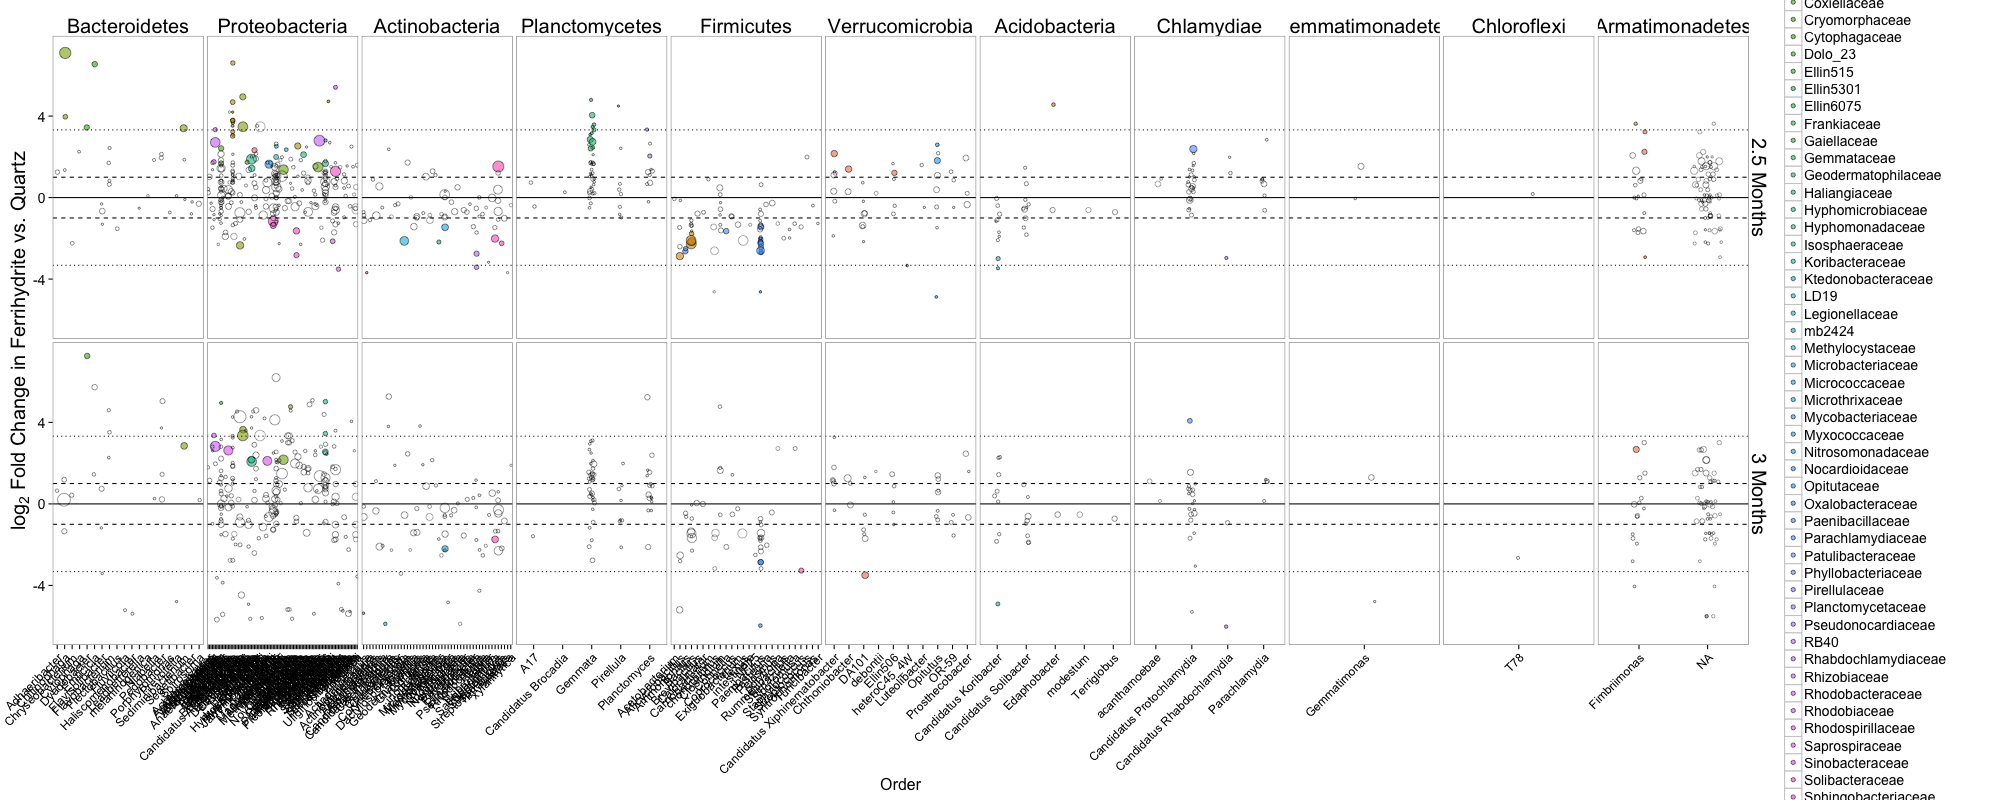

In [38]:
%%R -w 2000 -h 800
# setting the image sizes, then making the figure...

d = l2fc

d = dplyr::group_by(d, Trtmt, Month) %>%
                dplyr::mutate(relabund=baseMean/sum(baseMean))
head(d$relabund)

N=50

Phyla = levels(d$Phylum)

NPhylum <- function (x){
    m = c()
    for (i in x){
       L <- length(d$Phylum[d$Phylum==i])
    if (L > N) m = c(m,i)
        }
        m
    }

Include<-as.factor(NPhylum(Phyla))
d<-d[d$Phylum %in% Include,]
d$Phylum<-factor(d$Phylum)
    
d$MonthName = ifelse(d$Month==2,"2 Months",(ifelse(d$Month==2.5, "2.5 Months","3 Months")))
d$strip1 = paste(d$MonthName)
# Creates a "strip" column of d with Months

max.l2FC = ddply(d, .(Phylum), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Phylum = factor(d$Phylum, max.l2FC[order(-max.l2FC$M),]$Phylum)
# takes our phylum column, and arranges it in order of our log2FoldChange values


d$sig = ifelse(d$padj<=0.1,"yes","NS")
d$sig = ifelse(is.na(d$padj),"NS",paste(d$sig))

d.yes = d[d$sig=="yes",]
d.no = d[d$sig=="NS",]

p = ggplot(d, aes(x=Species, y=l2FC))

p = p + geom_point(data=d.yes, aes(x = Genus, y = l2FC, fill = Family, size=relabund), shape = 21, alpha=0.6, position = position_jitter(w = 0.10))
p = p + geom_point(data=d.no, aes(x = Genus, y = l2FC, size=relabund), shape = 21, alpha=0.5, position = position_jitter(w = 0.10))


p = p + facet_grid(~strip1~Phylum, scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

p = p + geom_point(shape = 21, alpha = 0.4, position = position_jitter(w = 0.20), aes(size = relabund))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)", trans="log")
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 16),
              axis.text.y = element_text(size=14),
              axis.title.y = element_text(size = 20),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Order")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," Fold Change in Ferrihydrite vs. Quartz",sep="")))
# sets the label for the y axes.

#p = p + scale_color_continuous(trans="log")    
#p = p + scale_fill_discrete(guide="none")
    
colourCount = length(unique(d$Genus))
getPalette = colorRampPalette(brewer.pal(8, "Dark2"))
p = p + scale_colour_manual(values=c("grey",getPalette(colourCount)))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p

Planctomycetes are consistently enriched in Fe vs. quartz. - some do anammox, nucleoids, no peptidoglycan

In [36]:
%%R

cutoff=2

d.high = l2fc %>%
# Take the l2fc data frame,
    dplyr::filter(l2FC>cutoff, padj<0.1)%>%
# Include only the 2.5 month samples and take the rows where
# log2fold change is higher than cutoff, and the FDR (padj) is less than 0.1.
    dplyr::group_by(Month) %>%
# Then, treating each month separately,
    dplyr::mutate(relabund=baseMean/sum(baseMean)) %>%
# Create a new column called relabund, which is the mean normalized count, divided by the total
# (total of those we selected, not of the whole dataset). 
    dplyr::group_by(Family, Month) %>%
# Then, using this data, still grouped by month, we further group it by phylum,
    dplyr::summarise(relabund=sum(relabund))
# And we tally up all the relative counts for each taxonomic group.

colnames(d.high) <- c("Tax","Month","relabund")
# Set the column names to generic so it's easier to change the order, etc.

mean.Abund = ddply(d.high, .(Tax), summarize, M = mean(relabund))
# Calculate the phyla's mean abundances
d.high$Tax = factor(d.high$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the phyla by abundance
d.high<-d.high[with(d.high, order(Tax)),]
# Sort the whole dataframe by this phylum order


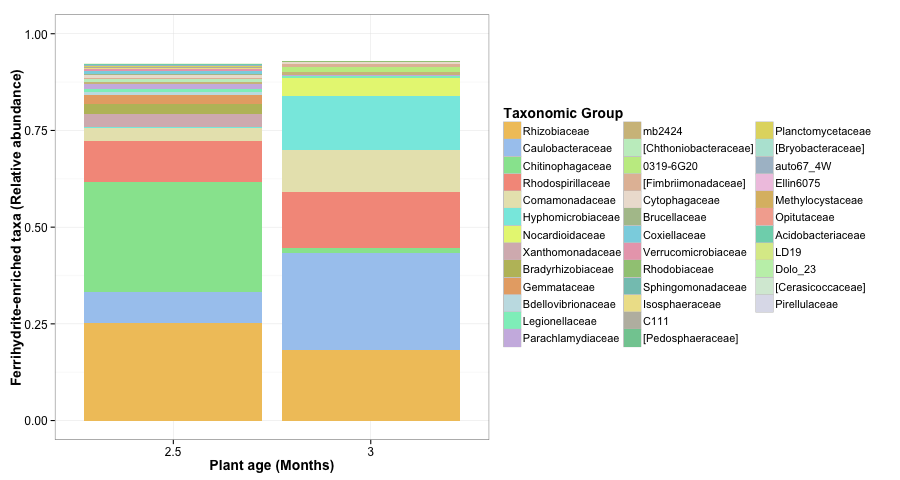

In [20]:
%%R -w 900

d.plot = d.high

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)
d.plot$Month <- as.factor(d.plot$Month)

p = ggplot(d.plot, aes(x=Month,y=relabund,fill = Tax))

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.90)

p = p + guides(fill = guide_legend(title="Taxonomic Group", ncol = 3))

p = p + xlab("Plant age (Months)") + ylab("Ferrihydrite-enriched taxa (Relative abundance)")

p = p + theme_bw()

p = p + theme(axis.title = element_text(size=14,face="bold"))
p = p + theme(axis.text = element_text(size=12,))
p = p + theme(legend.text=element_text(size=11))
p = p + theme(legend.title=element_text(size=14))

p

Rhodospirillales (enriched in F at 2.5 months) is mostly purple nonsulfur bacteria (includes magnetospirillum!)  
Chitinophaga still enriched in F at 2.5 months  
Devosia (somewhat enriched at 2.5 and highly enriched at 3 months) may be flagellated gram- bact. from Rhizobiales (alpha-proteo)

##Checking Fe taxa

In [21]:
%%R
Fe = c("Shewanella","Geobacter","Ferribacterium","Thiobacillus","Rhodovulum","Rhodobacter","Rhodomicrobium",
       "Rhodopseudomonas","Gallionella","Sideroxydans","Ferrovum","Ferritrophicum","Leptothrix",
      "Acidithiobacillus","Thiodictyon","Acidiferrobacter","Mariprofundis","Thermomonas","Acidovorax","Aquabacterium",
      "Pseudogulbenklania","Azospira","Paracoccus","Pseudogulbenkiania","Sphaerotilus","Marinobacter","Acidimicrobium",
      "Ferrimicrobium","Ferrithrix","Alicyclobacillus","Chlorobium","Leptospirillum","Aquifex","Ferroplasma",
      "Acidiplasma","Ferroglobus","Sulofolobus","Acidianus","Metallosphaera","Desulfobivrio","Thermus",
       "Thermoterrabacterium","Desulfotomaculum","Geothrix","Ferrimonas","Acidiphilum",
      "Sulfurospirillum","Deferribacter","Thermodesulfobacterium","Thermotoga","Sulfolobus","Pyrococcus",
       "Archaeoglobus","Methanococcus","Desulfuromusa","Pelobacter","Desulfuromonas","Desulfomonile","Geospirillum")
# Could include Bacillus and Clostridium, but perhaps too general

In [22]:
%%R

d.Fe = l2fc %>%
#    dplyr::filter(padj<=0.1)%>%
    dplyr::group_by(Trtmt,Month) %>%
    dplyr::mutate(relabund=baseMean/sum(baseMean))%>%
    dplyr::filter(Genus %in% Fe)%>%
    dplyr::select(Month,Trtmt,OTU,l2FC,Phylum,Family,Genus,Species,relabund,l2FC,padj)
# This gives us a list of all the possible swarmer cells, based on their genus.
# If their l2FC is consistently positive, this might support the idea that swarming helps colonization

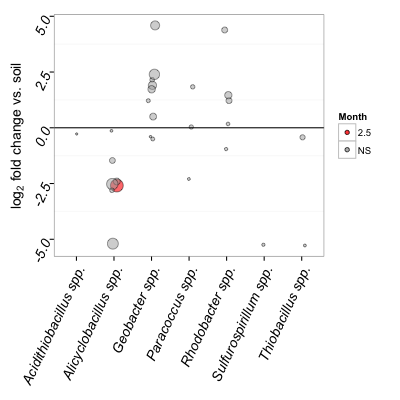

In [28]:
%%R -w 400 -h 400

d = d.Fe

d = d %>%
    mutate(Species = paste(Genus,"spp."))

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
d$sig = ifelse(d$padj<=0.1,"yes","NS")
d$sig = ifelse(is.na(d$padj),"NS",paste(d$sig))
d$Month = as.factor(d$Month)
#d$Month = ifelse(d$Month==2,"1 Month",(ifelse(d$Month==2.5, "1.5 Months","2 Months")))

d.yes = d[d$sig=="yes",]
d.no = d[d$sig=="NS",]

p = ggplot(d, aes(x=Species, y=l2FC))

p = p + geom_point(data=d.yes, aes(x = Species, y = l2FC, fill = Month, size=relabund), shape = 21, alpha=0.6, position = position_jitter(w = 0.10))
p = p + geom_point(data=d.no, aes(x = Species, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.5, position = position_jitter(w = 0.10))

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
p = p + scale_fill_manual(values=c("red","darkgrey"))
p = p + geom_hline(aes(yintercept=0))
p = p + theme_bw()
p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
p = p + theme(axis.text = element_text(angle=65,hjust=1, size=14, face="italic"),
            strip.background = element_blank(),
            strip.text = element_text(size=14),
             axis.title.x = element_blank(),
             axis.title.y = element_text(size=14),
             panel.grid.major = element_blank())
p

In [40]:
%%R
d = l2fc %>%
    filter(Phylum=="Planctomycetes")
d$Genus

  [1] <NA>                <NA>                <NA>               
  [4] <NA>                Candidatus Brocadia <NA>               
  [7] <NA>                <NA>                <NA>               
 [10] <NA>                <NA>                <NA>               
 [13] <NA>                <NA>                <NA>               
 [16] <NA>                <NA>                <NA>               
 [19] <NA>                <NA>                <NA>               
 [22] <NA>                <NA>                <NA>               
 [25] <NA>                <NA>                <NA>               
 [28] <NA>                <NA>                <NA>               
 [31] <NA>                <NA>                <NA>               
 [34] <NA>                <NA>                <NA>               
 [37] <NA>                <NA>                <NA>               
 [40] <NA>                <NA>                <NA>               
 [43] <NA>                <NA>                <NA>               
 [46] <NA>